<a href="https://colab.research.google.com/github/kavyajeetbora/end_to_end_gee_with_python/blob/master/%20Google%20Earth%20Engine%20with%20Amirhossein%20Ahrari/002_Landsat%20Monthly%20LST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting the monthly landsat data

- Here we will try to plot the monthly landsat data by aggregating the image collection month wise and reduce them by median values
- Also in this exercise we will merge landsat 8 and landsat 9 data for better data quality
- Plot the results
- Plot a timeseries of the aggregated results

This notebook is based on this video:

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/JLFcyTt-das/0.jpg)](https://www.youtube.com/watch?v=JLFcyTt-das)

In [13]:
import geemap
import ee
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

In [2]:
def filterImageCollection(
        image_collection_id: str,
        geometry: ee.geometry.Geometry,
        date_range: tuple[str],
        cloud_cover = 10
    ) -> ee.imagecollection.ImageCollection:

    imageCollection = ee.ImageCollection(image_collection_id)
    d1,d2 = date_range
    filtered = imageCollection.filter(
       ee.Filter.lt('CLOUD_COVER', 10)
    )\
    .filter(
        ee.Filter.date(d1, d2) ## Filter by date
    ).filter(
        ee.Filter.bounds(geometry) ## Filter by bounds
    )

    return filtered

## Filtering the data



### Get the geometry for area of interest

In [3]:
## Get the area of interest
admin = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
delhi = admin.filter(ee.Filter.eq('ADM1_NAME', 'Delhi'))\
.filter(ee.Filter.eq('ADM2_NAME', 'Delhi'))

geometry = delhi.geometry()

## Get the landsat image collection data

**About Landsat**

Landsat, a joint program of the USGS and NASA, has been observing the Earth continuously from 1972 through the present day. Today the Landsat satellites image the entire Earth's surface at a 30-meter resolution about once every two weeks (**Revisit Interval
16 days**), including multispectral and thermal data. The USGS produces data in 3 categories for each satellite (Tier 1, Tier 2 and RT)

Landsat collection structure.
The USGS produces data in 3 tiers (categories) for each satellite:

1. Tier 1 (T1) - Data that meets geometric and radiometric quality requirements
2. Tier 2 (T2) - Data that doesn't meet the Tier 1 requirements
3. Real Time (RT) - Data that hasn't yet been evaluated (it takes as much as a month).

In [4]:
y1,y2 = (2023, 2024)
cloud_cover = 45
date_range = (f"{y1}-01-01", f"{y2}-01-01")

## get the landsat 8 image collection
landsat8 = filterImageCollection(
    image_collection_id = "LANDSAT/LC08/C02/T1_L2",
    geometry = geometry,
    date_range = date_range,
    cloud_cover = cloud_cover
)

## get the landsat 8 image collection
landsat9 = filterImageCollection(
    image_collection_id = "LANDSAT/LC09/C02/T1_L2",
    geometry = geometry,
    date_range = date_range,
    cloud_cover = cloud_cover
)

## merge the image collection
## Sort them as per time
landsat = landsat8.merge(landsat9).sort('system:time_start')

Using `pandas.date_range` to generate the monthly dates

use `freq` parameter to decide how to divide the range, whether daily or monthly.

See the `freq` notations here: [Offset aliases](https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases)

In [5]:
## Generating a monthly range of dates
monthly_range = pd.date_range(start=f'1/1/{y1}', end=f'01/01/{y2}', freq='MS').strftime('%Y-%m-%d')
monthly_range

Index(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
       '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
       '2023-11-01', '2023-12-01', '2024-01-01'],
      dtype='object')

In [10]:
def resample_img_collection(image_collection: ee.imagecollection.ImageCollection, monthly_range:list) -> ee.imagecollection.ImageCollection:

    '''
    Downsampling an image collection by a specfic date range, like monthly or weekly
    Returns an image collection down sampled
    The default aggregation of the images is set as median values
    '''
    collection = []

    for i in range(0, len(monthly_range)-1):
        d1,d2 = monthly_range[i], monthly_range[i+1]
        c = image_collection.filter(ee.Filter.date(d1,d2))
        d1_unix, d2_unix = list(map(lambda x: ee.Date(x).millis(), [d1,d2]))
        c = c.median().set('system:time_start', d1_unix).set('system:time_end', d2_unix)
        collection.append(c)

    new_img_collection = ee.ImageCollection(collection)
    return new_img_collection

landsat_monthly = resample_img_collection(landsat, monthly_range)

## Visualize the results

In landsat there are multiple bands from which we can plot the RGB image, any spectral indices like NVDI or the surface temperature as mentioned in the documentation

Here we will visualize the surface temperature represented by `ST_B10` band

In [11]:
def rescale_image(image):
    temp = image.select('ST_B10').multiply(0.00341802).add(149).rename('temp') ## in kelvin
    temp = temp.subtract(273.15)
    return temp.copyProperties(image, ['system:time_start', 'system:time_end'])

surf_temp = landsat_monthly.map(rescale_image)
surf_temp.size()

In [43]:
Map = geemap.Map()

## Calculate the median composite and select values greater than 0 only
## Finding the median over all months
temp = surf_temp.median().clip(geometry)

vizParams = {
    'min': 0,
    'max': 40,
    'palette': ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
}

Map.addLayer(temp.clip(geometry), vizParams, 'Surface Temperature')

Map.centerObject(geometry, 12)
Map

Map(center=[28.64654955564474, 77.10895454636062], controls=(WidgetControl(options=['position', 'transparent_b…

## Plotting the time series


In [39]:
def summarizeRegion(image, geometry, bandName):
    '''
    Compute the median regional stat of a given image
    and store it in image property metadata
    '''
    stat = ee.Number(image.reduceRegion(
        reducer = ee.Reducer.median(),
        geometry = geometry,
        scale = 10, ## scale = 10 m pixel, gee will down/up sample the image as required
        maxPixels = 1e10
    ).get(bandName))

    return image.set('average_stat', stat)


# Get a list of dictionaries containing image information

def extract_time_series(image_collection, stat_prop='average_stat', time_prop='system:time_start'):
    '''
    Extract timeseries values, the average values and the time
    here time will be converted to python datetime object
    It will set as none where average value is not found
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    x, y = [], []
    for prop in properties:
        try:
            stat = prop[stat_prop]
            time = prop[time_prop]/1000 ## in seconds
            time = datetime.fromtimestamp(time) #.strftime('%Y-%m-%d')
        except:
            stat = float('nan')

        y.append(stat)
        x.append(time)

    return x,y

def plot_time_series(x,y, title='Average Surface Temperature'):
    '''
    Plot the time series given the x - datetime, y- stat
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(x,y)
    ax.set_xlabel("Date")
    ax.set_ylabel(title)
    ax.set_title(title)
    return fig

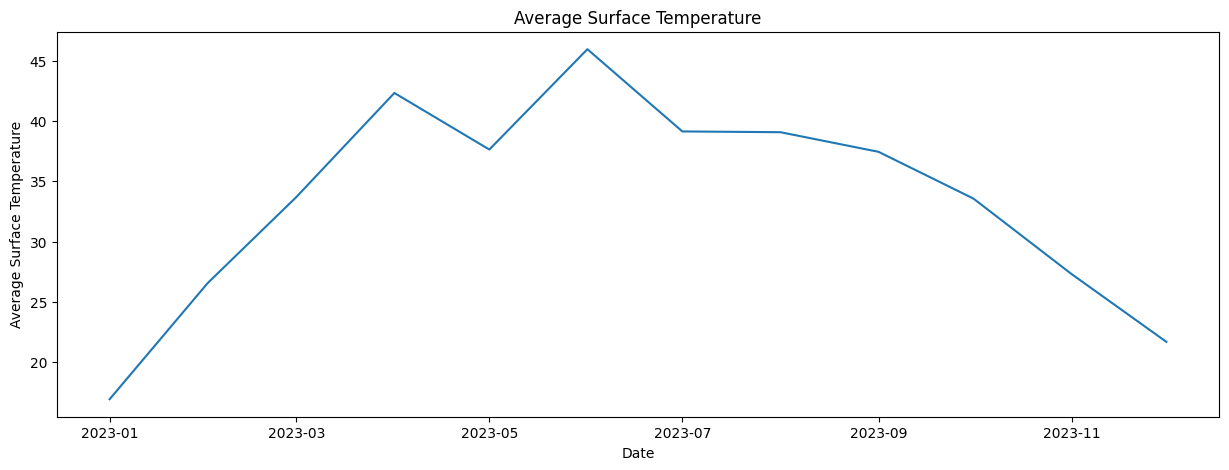

In [40]:
## Summarize the image over region, compute the median of an image over the region
temp_avg = surf_temp.map(lambda image: summarizeRegion(image, geometry, bandName="temp"))

## Extract the median temp value and time for each image
x,y = extract_time_series(temp_avg, stat_prop='average_stat', time_prop="system:time_start")

## Plot the time series
fig = plot_time_series(x,y)

## Resources

1. [ee.Date](https://developers.google.com/earth-engine/apidocs/ee-date)
2. [ee.ImageCollection.merge](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-merge)